<a href="https://colab.research.google.com/github/iannashon/cse6250/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import os
import re
import shutil
import string
import tensorflow as tf
from sklearn.model_selection import train_test_split
from collections import Counter

import numpy as np
from gensim.models.keyedvectors import KeyedVectors
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from numpy import savetxt
from numpy import save
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from sklearn.metrics import confusion_matrix,classification_report
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import *

In [3]:
# if tf.test.gpu_device_name(): 
#     print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

# else:
#     print("Please install GPU version of TF")

In [4]:
# Load our dataset
dataset = pd.read_csv("drive/MyDrive/mimicdb/dataset_05.csv")
# dataset.count()

# dataset.head()

In [5]:
# xx = dataset["isEarlyReadmission"].value_counts().reset_index()
# sns.barplot(x="index", y="isEarlyReadmission", data=xx, palette="cividis")

In [6]:
msk = np.random.rand(len(dataset)) < 0.04
sample_df = dataset[msk]
# print(len(sample_df))
dataset= sample_df

In [7]:
def remove_numbers_and_special_character(text):
    text_cln = re.sub('[^A-Za-z]+', ' ', str(text))
    return text_cln
  

def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()


def split_dataset(train_data, target_column_name):
  X_train, X_valid, y_train, y_valid = train_test_split(train_data['TEXT'].tolist(),\
                                                      train_data[target_column_name].tolist(),\
                                                      test_size=0.3,\
                                                      random_state=42)
  return X_train, X_valid, y_train, y_valid


def split_dataset_x(train_data, target_label):
  X_train, X_valid, y_train, y_valid = train_test_split(train_data['TEXT'].tolist(),\
                                                      train_data[target_label].tolist(),\
                                                      test_size=0.1,\
                                                      random_state=42)
  return X_train, X_valid, y_train, y_valid


def get_target_train(train_data, label):
   return train_data['TEXT'].tolist(), train_data[label].tolist()


In [8]:
# cleaning
dataset['TEXT'] = dataset['TEXT'].apply(remove_numbers_and_special_character)
dataset['TEXT'] = dataset['TEXT'].apply(clean_text)
# print(len(dataset))

In [9]:
train, Xtest, label, Ytest = split_dataset(dataset, "isEarlyReadmission")

In [10]:
model_w2v = KeyedVectors.load_word2vec_format('drive/MyDrive/mimicdb/PubMed-w2v.bin', binary=True)

In [11]:
def word_embedding(train, model):
  features = []
  for data in train:
    # print(data)
    text_splt = data.split()
    txt_arry = []
    for text in text_splt:
      if text in model:
        txt_arry.append(model[text])
    
    txt_arry_np = np.asarray(txt_arry).astype(np.float32)
    features.append(txt_arry_np)

  return np.array(features)

def label_encoder(y_train):
  le = LabelEncoder()
  train_labels = le.fit_transform(y_train)
  train_labels = np.asarray(tf.keras.utils.to_categorical(y_train))
  return train_labels


def padding(p_train):
  # padding_ln=dataset.loc[dataset['TEXT_LN'].idxmax()]["TEXT_LN"]
  padding_ln = 1000
  inputs = pad_sequences(p_train, padding='post', maxlen=padding_ln, dtype='float32')
  # inputs = inputs.astype(np.float32)
  return inputs


def create_features(x_train, y_train,  model_w2v ):
  train = word_embedding(x_train, model_w2v)
  # print(train.shape)
  targets = label_encoder(y_train)
  inputs = padding(train)
  # print(inputs.shape)
  return inputs, targets



In [12]:
# feature creation
inputs, targets = create_features(train, label, model_w2v)
inputsTest, targetsTest = create_features(Xtest, Ytest, model_w2v)

<ipython-input-11-991db4c8ff48>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(features)


In [13]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
num_folds = 10
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
# loss_function = sparse_categorical_crossentropy
no_epochs = 100
batch_size = 128
verbosity = 1
acc_per_fold = []
loss_per_fold = []
optimizer = Adam()
hidden_dims = 250 

for train, test  in kfold.split(inputs, targets ):

  # Define the model architecture
  model = tf.keras.Sequential()                               
  model.add(tf.keras.layers.Conv1D(128,3, activation='relu',\
                                  kernel_regularizer = regularizers.l2(0.0005),\
                                  bias_regularizer = regularizers.l2(0.0005)))                               
  model.add(tf.keras.layers.GlobalMaxPooling1D())
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(2, activation='sigmoid',\
                                  kernel_regularizer=regularizers.l2(0.001),\
                                  bias_regularizer=regularizers.l2(0.001),))

  # Compile the model

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=["accuracy", "Recall", "Precision", f1_m])

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  
  random.seed(1234)
  history = model.fit(inputs[train], targets[train],
              batch_size=batch_size,
              epochs=no_epochs,
              validation_data=(inputs[test], targets[test]),
              verbose=verbosity)

  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
3/3 [==============================] - 5s 268ms/step - loss: 0.7291 - accuracy: 0.6400 - recall: 0.1086 - precision: 0.4000 - f1_m: 0.1937 - val_loss: 0.4204 - val_accuracy: 0.9231 - val_recall: 0.4359 - val_precision: 0.8947 - val_f1_m: 0.5862
Epoch 2/100
3/3 [==============================] - 0s 47ms/step - loss: 0.4082 - accuracy: 0.9314 - recall: 0.6000 - precision: 0.9375 - f1_m: 0.7315 - val_loss: 0.3592 - val_accuracy: 0.9231 - val_recall: 0.6410 - val_precision: 0.9259 - val_f1_m: 0.7576
Epoch 3/100
3/3 [==============================] - 0s 46ms/step - loss: 0.3742 - accuracy: 0.9314 - recall: 0.7286 - precision: 0.9410 - f1_m: 0.8235 - val_loss: 0.3550 - val_accuracy: 0.9231 - val_recall: 0.6923 - val_precision: 0.9310 - val_f1_m: 0.7941
Epoch 4/100
3/3 [==============================] - 0s 49ms/step - loss: 0.3668 - accuracy: 0.9314 - recall: 0.7543 - precision: 0.9329

In [15]:
# print(len(inputsTest))
# print(len(targetsTest))
# print(len(inputs))
# print(len(targets))
loss, accuracy, f1_score, precision, recall = model.evaluate(inputsTest, targetsTest, verbose=0)

In [16]:
print(f"loss {loss}")
print(f"accuracy { accuracy}")
print(f"f1_score  {f1_score}")
print(f"precision {precision}")
print(f"recall {recall}")

loss 0.3191714286804199
accuracy 0.9451219439506531
f1_score  0.9451219439506531
precision 0.9451219439506531
recall 0.9531249403953552


In [15]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

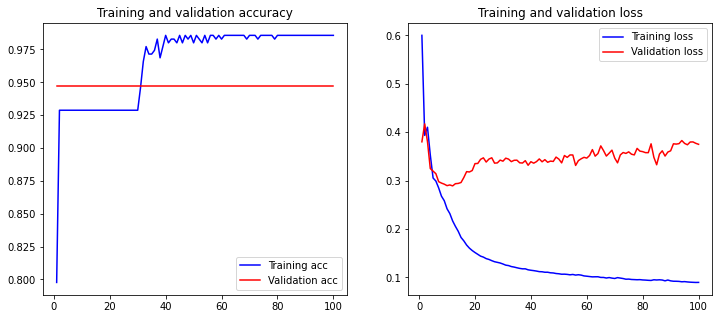

In [16]:
plot_history(history)
# print(history[0])
# history_dict = history.history
# print(history_dict.keys())

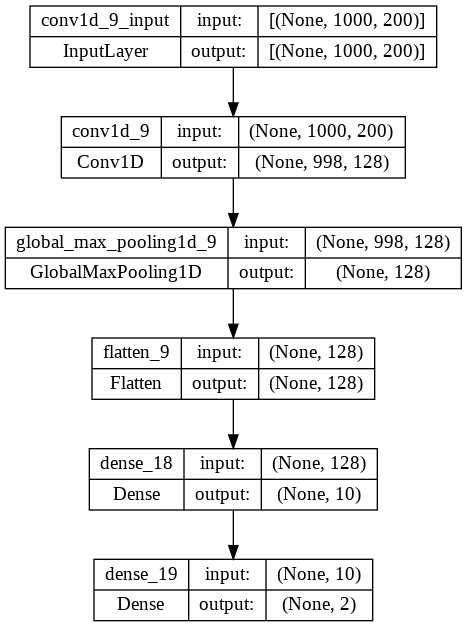

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)